In [128]:
import os 

In [129]:
dataset_path = './train/plain'
df = os.listdir(dataset_path)

print(df)
print("Total images:", len(df))

['champaign_s_000124.png', 'champaign_s_000131.png', 'champaign_s_000135.png', 'champaign_s_000226.png', 'champaign_s_000468.png', 'champaign_s_000486.png', 'field_s_000007.png', 'field_s_000009.png', 'field_s_000011.png', 'field_s_000015.png', 'field_s_000021.png', 'field_s_000026.png', 'field_s_000036.png', 'field_s_000040.png', 'field_s_000041.png', 'field_s_000044.png', 'field_s_000049.png', 'field_s_000064.png', 'field_s_000072.png', 'field_s_000090.png', 'field_s_000104.png', 'field_s_000105.png', 'field_s_000117.png', 'field_s_000120.png', 'field_s_000153.png', 'field_s_000156.png', 'field_s_000164.png', 'field_s_000173.png', 'field_s_000179.png', 'field_s_000183.png', 'field_s_000184.png', 'field_s_000192.png', 'field_s_000201.png', 'field_s_000211.png', 'field_s_000221.png', 'field_s_000226.png', 'field_s_000241.png', 'field_s_000249.png', 'field_s_000308.png', 'field_s_000310.png', 'field_s_000312.png', 'field_s_000316.png', 'field_s_000339.png', 'field_s_000385.png', 'field_

In [130]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import glob
import numpy as np
from PIL import Image

In [131]:
import shutill
import random
import math

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [132]:
IMAGE_SIZE = 32        
CHANNELS = 3
BATCH_SIZE = 64
LATENT_DIM = 256
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [133]:
import os

PROJECT_ROOT = r"C:\Users\ASUS\Documents\uts-deeplearning-2702352250\CIFAR-100-dataset"
TRAIN_DIR = os.path.join(PROJECT_ROOT, "train", "plain")
TEST_DIR  = os.path.join(PROJECT_ROOT, "test", "plain")

OUT_DIR = os.path.join(PROJECT_ROOT, "outputs")
GEN_DIR = os.path.join(OUT_DIR, "generated")
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
MODEL_DIR = os.path.join(OUT_DIR, "models")

os.makedirs(GEN_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("Train folder:", TRAIN_DIR)
print("Test folder:", TEST_DIR)
print("Train images:", len(os.listdir(TRAIN_DIR)))
print("Test images:", len(os.listdir(TEST_DIR)))


Train folder: C:\Users\ASUS\Documents\uts-deeplearning-2702352250\CIFAR-100-dataset\train\plain
Test folder: C:\Users\ASUS\Documents\uts-deeplearning-2702352250\CIFAR-100-dataset\test\plain
Train images: 500
Test images: 100


In [134]:
def load_image_paths(folder):
    exts = ("*.png","*.jpg","*.jpeg")
    files=[]
    for e in exts:
        files += glob.glob(os.path.join(folder, e))
    return sorted(files)

In [135]:
def load_images_array(paths, image_size=IMAGE_SIZE):
    imgs=[]
    for p in paths:
        img = Image.open(p).convert("RGB").resize((image_size,image_size))
        imgs.append(np.array(img))
    arr = np.array(imgs).astype("float32")
    arr = (arr / 127.5) - 1.0   # [-1,1]
    return arr

In [136]:

all_paths = load_image_paths(TRAIN_DIR)
print("Total images:", len(all_paths))

Total images: 500


In [137]:
val_count = max(64, int(0.05*len(all_paths)))   # 5% or at least 64
val_paths = all_paths[:val_count]
train_paths = all_paths[val_count:]
print("Train:", len(train_paths), "Val:", len(val_paths))
train_images = load_images_array(train_paths)
val_images = load_images_array(val_paths)

Train: 436 Val: 64


In [138]:

train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(val_images).batch(BATCH_SIZE)

In [139]:
def make_generator(latent_dim=LATENT_DIM):
    return tf.keras.Sequential([
        layers.Dense(4*4*256, input_shape=(latent_dim,)),
        layers.Reshape((4,4,256)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.2),

        layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.2),

        layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.2),

        layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh'),
    ])


In [140]:
def make_discriminator():
    d = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.LeakyReLU(0.2),
        layers.GaussianNoise(0.05),

        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.GaussianNoise(0.05),

        layers.Flatten(),
        layers.Dense(1)
    ], name="Discriminator")
    return d


In [141]:
generator = make_generator()
discriminator = make_discriminator()
generator.summary(); discriminator.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,713,091 (6.53 MB)

 Trainable params: 1,712,195 (6.53 MB)

 Non-trainable params: 896 (3.50 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_4                │ (None, 16, 16, 64)     │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_5                │ (None, 8, 8, 128)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,529 (556.75 KB)

 Trainable params: 142,529 (556.75 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:

g_opt = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(3e-5, beta_1=0.5)


In [143]:
def train_step(batch_real):
    batch_size = tf.shape(batch_real)[0]
    noise = tf.random.normal([batch_size, LATENT_DIM])

    smooth_real = 0.9   # label smoothing

    with tf.GradientTape() as gt, tf.GradientTape() as dt:
        fake = generator(noise, training=True)

        real_logits = discriminator(batch_real, training=True)
        fake_logits = discriminator(fake, training=True)

        # --- Apply label smoothing here ---
        d_loss_real = cross_entropy(smooth_real * tf.ones_like(real_logits), real_logits)
        d_loss_fake = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
        d_loss = (d_loss_real + d_loss_fake) / 2.0

        g_loss = cross_entropy(tf.ones_like(fake_logits), fake_logits)

    g_grads = gt.gradient(g_loss, generator.trainable_variables)
    d_grads = dt.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    return g_loss, d_loss


In [144]:
def eval_on_validation(batch_real):
    batch_size = tf.shape(batch_real)[0]
    noise = tf.random.normal([batch_size, LATENT_DIM])
    fake = generator(noise, training=False)
    r = discriminator(batch_real, training=False)
    f = discriminator(fake, training=False)
    d_loss = (cross_entropy(tf.ones_like(r), r) + cross_entropy(tf.zeros_like(f), f)) / 2.0
    g_loss = cross_entropy(tf.ones_like(f), f)
    return g_loss, d_loss

In [145]:
EPOCHS = 120
steps_per_epoch = max(1, len(train_images)//BATCH_SIZE)
history = {"g_train":[], "d_train":[], "g_val":[], "d_val":[]}
fixed_noise = tf.random.normal([16, LATENT_DIM])

In [146]:
for epoch in range(EPOCHS):
    g_accum = 0.0; d_accum = 0.0; n=0
    for batch in train_ds:
        g_loss, d_loss = train_step(batch)
        g_accum += float(g_loss); d_accum += float(d_loss); n+=1
    g_train = g_accum / n; d_train = d_accum / n
    
    # validation: average over val batches
    g_val_acc=0.0; d_val_acc=0.0; m=0
    for vbatch in val_ds:
        gv, dv = eval_on_validation(vbatch)
        g_val_acc += float(gv); d_val_acc += float(dv); m+=1
    g_val = g_val_acc / max(1,m); d_val = d_val_acc / max(1,m)
    history["g_train"].append(g_train); history["d_train"].append(d_train)
    history["g_val"].append(g_val); history["d_val"].append(d_val)
    print(f"Epoch {epoch+1}/{EPOCHS}  g_train={g_train:.4f} d_train={d_train:.4f}  g_val={g_val:.4f} d_val={d_val:.4f}")
    
    
    # save sample every 10 epochs
    if (epoch+1) % 10 == 0:
        samples = (generator(fixed_noise, training=False) + 1.0)/2.0
        grid = tf.concat([samples[i] for i in range(samples.shape[0])], axis=1)  
        
        
        # save individual 16 images
        for i in range(outp.shape[0]):
            Image.fromarray(outp[i]).save(os.path.join(GEN_DIR, f"sample_e{epoch+1}_{i}.png"))
        generator.save(os.path.join(MODEL_DIR,f"generator_e{epoch+1}.keras"))
        discriminator.save(os.path.join(MODEL_DIR,f"discriminator_e{epoch+1}.keras"))

Epoch 1/120  g_train=0.6794 d_train=0.6930  g_val=0.6908 d_val=0.6668
Epoch 2/120  g_train=0.6454 d_train=0.6959  g_val=0.6886 d_val=0.6491
Epoch 3/120  g_train=0.6290 d_train=0.6917  g_val=0.6878 d_val=0.6337
Epoch 4/120  g_train=0.6369 d_train=0.6772  g_val=0.6892 d_val=0.6192
Epoch 5/120  g_train=0.6465 d_train=0.6618  g_val=0.6909 d_val=0.6051
Epoch 6/120  g_train=0.6629 d_train=0.6437  g_val=0.6922 d_val=0.5917
Epoch 7/120  g_train=0.6767 d_train=0.6293  g_val=0.6939 d_val=0.5791
Epoch 8/120  g_train=0.6808 d_train=0.6177  g_val=0.6941 d_val=0.5685
Epoch 9/120  g_train=0.6766 d_train=0.6136  g_val=0.6917 d_val=0.5608
Epoch 10/120  g_train=0.6660 d_train=0.6139  g_val=0.6882 d_val=0.5565
Epoch 11/120  g_train=0.6557 d_train=0.6159  g_val=0.6875 d_val=0.5542
Epoch 12/120  g_train=0.6632 d_train=0.6124  g_val=0.6874 d_val=0.5537
Epoch 13/120  g_train=0.6860 d_train=0.6010  g_val=0.6920 d_val=0.5530
Epoch 14/120  g_train=0.7021 d_train=0.5983  g_val=0.6964 d_val=0.5541
Epoch 15/120  g

Part B Plotting 

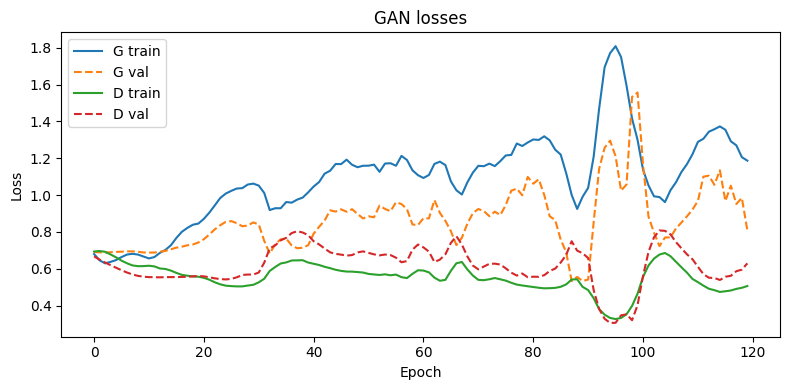

In [147]:
plt.figure(figsize=(8,4))
plt.plot(history["g_train"], label="G train")
plt.plot(history["g_val"], label="G val", linestyle="--")
plt.plot(history["d_train"], label="D train")
plt.plot(history["d_val"], label="D val", linestyle="--")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("GAN losses")
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,"gan_losses.png")); plt.show()


I think the GAN training is stable and balanced, there's some spikes around epoch 90-100. Training is a bit balanced because the difference between G and D losses is smaller than other parameters that I tried which is good. Generator is improving, slowly because training curves indicate learning but not strong convergence yet.


1. Generator Training Loss:
- Slowly increases from ~0.7 → ~1.2 across training
- Rise to 1.8 at epoch 95 which means the discriminator briefly became too strong or output quality dropped or noise injection / regularization caused temporary instability
- Drops again and stabilizes around 1.2, it recovers, training is still stable.


Generator is gradually making harder attempts to fool the discriminator (normal for GANs).


2. Generator Validation Loss
- Similar pattern to training loss
- Wavy and but less wavy than G-loss
- Major spike near epoch 95–100
- Stays elevated but not diverging


The generator is not overfitting excessively
Validation follows training. The spike corresponds exactly to the spike in G train because model instability, not overfitting.

3. Discriminator Training Loss 
- Low and stable: around 0.45–0.65
- Little movement
- No collapse

The discriminator is strong but not overpowering
Much more balanced than earlier runs
The slight upward drift near the end means it occasionally gets confused 

4. Discriminator Validation Loss (red, dashed)
Observations:
- Higher than D train (normal)
- Mild oscillations
- Sharp dip near epoch 95 (when G spikes) Then returns to normal


The discriminator was briefly overconfident during the spike, it classified fake images extremely confidently that caused G loss to shoot up but then training recovered. This is a mini-collapse that self-corrects.


Part C Generate 500 images

In [148]:
def generate_n(n=500, batch=64):
    os.makedirs(GEN_DIR, exist_ok=True)
    cnt=0
    while cnt < n:
        b = min(batch, n-cnt)
        noise = tf.random.normal([b, LATENT_DIM])
        gen = (generator(noise, training=False)+1.0)/2.0
        gen_np = (gen.numpy()*255).astype("uint8")
        for i in range(b):
            Image.fromarray(gen_np[i]).save(os.path.join(GEN_DIR, f"fake_{cnt+i:04d}.png"))
        cnt += b
    print("Saved", n, "generated images to", GEN_DIR)

generate_n(500)


Saved 500 generated images to C:\Users\ASUS\Documents\uts-deeplearning-2702352250\CIFAR-100-dataset\outputs\generated


Part d

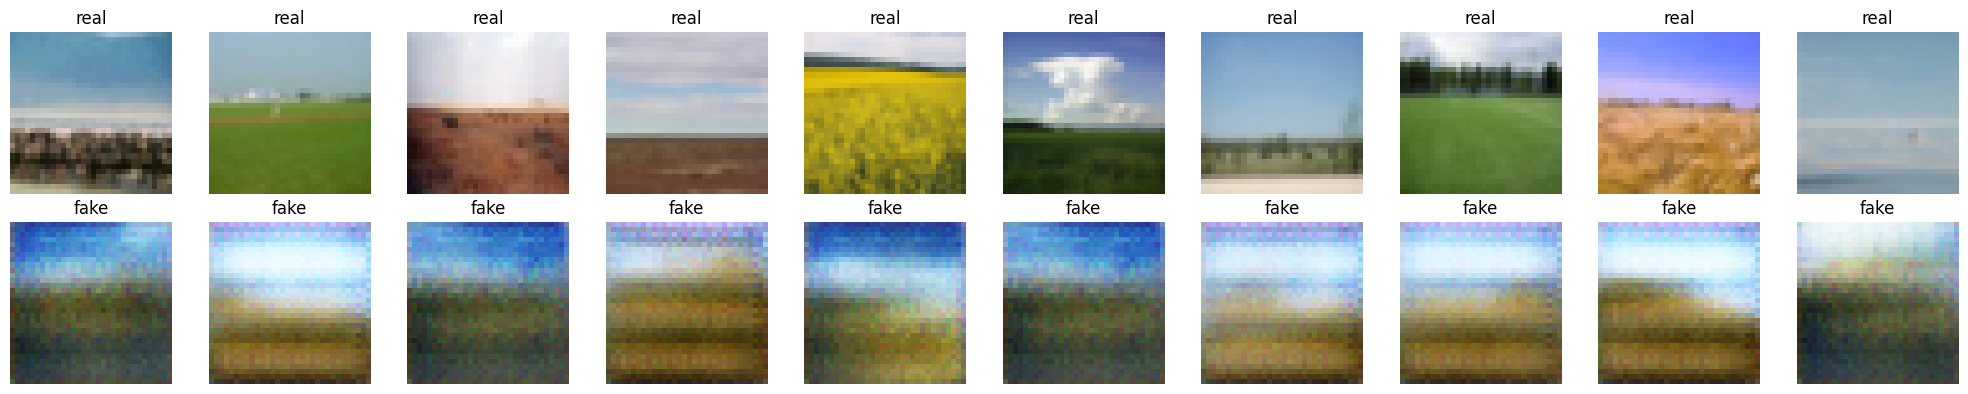

In [149]:
def make_compare_grid(real_paths, fake_dir, out_path=os.path.join(PLOTS_DIR,"compare_10v10.png")):
    real = random.sample(real_paths, 10)
    fake = random.sample(sorted(glob.glob(os.path.join(fake_dir,"*.png"))), 10)
    plt.figure(figsize=(20,4))
    for i,p in enumerate(real):
        plt.subplot(2,10,i+1); plt.imshow(Image.open(p).resize((32,32))); plt.axis("off"); plt.title("real")
    for i,p in enumerate(fake):
        plt.subplot(2,10,10+i+1); plt.imshow(Image.open(p)); plt.axis("off"); plt.title("fake")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

make_compare_grid(train_paths, GEN_DIR)



Original Images:
- Clearer and more detailed.
- Distinct elements such as grass, sky, clouds, buildings, or fields.
- Natural colors and sharp edges.



Generated Images (Bottom Row):
- Blurry and pixelated.
- Lack clear details or sharp patterns.
- Colors look washed out or overly smooth, more like rough painting

Why is that??

- Mode collapse might cause repetitive or overly smoothed textures.
- Insufficient training epochs or not enough data could limit generator performance.
- Low resolution output limits ability to generate fine details.
- GAN architecture might need deeper layers or improved loss functions (Wasserstein GAN).

Part e ori vs fake

In [ ]:
import shutil

os.makedirs(DATA_BINARY, exist_ok=True)
orig_dir = os.path.join(DATA_BINARY,"original"); fake_dir = os.path.join(DATA_BINARY,"fake")
shutil.rmtree(orig_dir, ignore_errors=True); shutil.rmtree(fake_dir, ignore_errors=True)
os.makedirs(orig_dir); os.makedirs(fake_dir)


real_candidates = train_paths.copy()
real_sample = random.sample(real_candidates, min(500, len(real_candidates)))
for i,p in enumerate(real_sample):
    shutil.copy(p, os.path.join(orig_dir, f"real_{i:04d}.png"))

fake_generated = sorted(glob.glob(os.path.join(GEN_DIR,"fake_*.png")))[:500]

for i,p in enumerate(fake_generated):
    shutil.copy(p, os.path.join(fake_dir, f"fake_{i:04d}.png"))
print("Binary dataset ready:", DATA_BINARY)


Binary dataset ready: ./CIFAR-100-dataset\data_binary


Part f 


In [151]:
IMG_SIZE_C = 96   
BATCH_C = 32
data_dir = DATA_BINARY
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, labels='inferred', label_mode='binary',
                                                                validation_split=0.3, subset='training', seed=SEED,
                                                                image_size=(IMG_SIZE_C,IMG_SIZE_C), batch_size=BATCH_C)
val_ds   = tf.keras.preprocessing.image_dataset_from_directory(data_dir, labels='inferred', label_mode='binary',
                                                                validation_split=0.3, subset='validation', seed=SEED,
                                                                image_size=(IMG_SIZE_C,IMG_SIZE_C), batch_size=BATCH_C)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE); val_ds = val_ds.prefetch(AUTOTUNE)



Found 936 files belonging to 2 classes.
Using 656 files for training.
Found 936 files belonging to 2 classes.
Using 280 files for validation.


In [152]:
base = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE_C,IMG_SIZE_C,3), include_top=False, weights='imagenet', pooling='avg')
base.trainable = False 
inp = layers.Input(shape=(IMG_SIZE_C,IMG_SIZE_C,3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inp)
x = base(x, training=False)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(1, activation='sigmoid')(x)
clf = tf.keras.Model(inp, out)
clf.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
clf.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [153]:

history_clf = clf.fit(train_ds, validation_data=val_ds, epochs=20)
clf.save(os.path.join(MODEL_DIR,"classifier_mobilenetv2.keras"))


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.7591 - loss: 0.5029 - val_accuracy: 0.9964 - val_loss: 0.1633
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9878 - loss: 0.1108 - val_accuracy: 1.0000 - val_loss: 0.0464
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9970 - loss: 0.0435 - val_accuracy: 1.0000 - val_loss: 0.0228
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9985 - loss: 0.0270 - val_accuracy: 1.0000 - val_loss: 0.0144
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 1.0000 - 

Part g Plotting

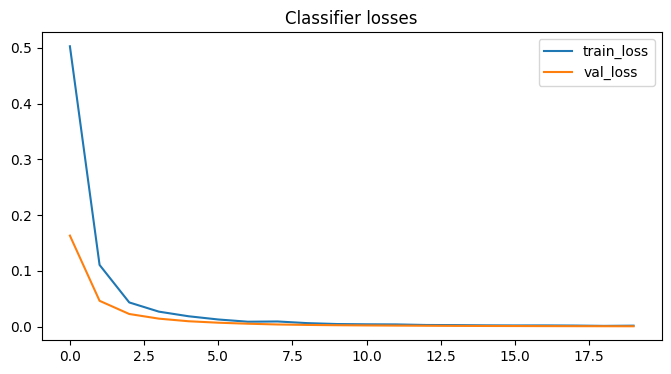

In [154]:
plt.figure(figsize=(8,4))
plt.plot(history_clf.history['loss'], label='train_loss')
plt.plot(history_clf.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Classifier losses"); plt.savefig(os.path.join(PLOTS_DIR,"classifier_losses.png")); plt.show()


The plot suggests that the training process is stable, with both training and validation losses decreasing and leveling off without signs of overfitting. It starts becoming stagnant at 5.0

Part h Hyperparameter Tuning

In [155]:
import kerastuner as kt

def build_model_hp(hp):
    base = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE_C,IMG_SIZE_C,3), include_top=False, weights='imagenet', pooling='avg')
    base.trainable = False
    inp = layers.Input((IMG_SIZE_C,IMG_SIZE_C,3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inp)
    x = base(x, training=False)
    x = layers.Dense(hp.Int('dense_units',32,256,step=32), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout',0.2,0.6,step=0.1))(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inp,out)
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('lr',[1e-3,1e-4,1e-5])), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [156]:
tuner = kt.RandomSearch(build_model_hp, objective='val_loss', max_trials=6, directory='kt_dir', project_name='fakeclf')
tuner.search(train_ds, validation_data=val_ds, epochs=8)
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

Reloading Tuner from kt_dir\fakeclf\tuner0.json
{'dense_units': 160, 'dropout': 0.5, 'lr': 0.001}


In [157]:

best_model = tuner.hypermodel.build(best_hp)
best_model.fit(train_ds, validation_data=val_ds, epochs=20)
best_model.save(os.path.join(MODEL_DIR,"classifier_tuned.keras"))


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9543 - loss: 0.1140 - val_accuracy: 1.0000 - val_loss: 1.4601e-04
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 6.7472e-04 - val_accuracy: 1.0000 - val_loss: 4.0517e-05
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 1.2417e-04 - val_accuracy: 1.0000 - val_loss: 3.8117e-05
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 8.0109e-05 - val_accuracy: 1.0000 - val_loss: 4.1357e-05
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 1.0546e-04 - val_accuracy: 1.0000 - val_loss: 3.7439e-05
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.1711e-04 - val_accuracy: 1.0000 - val_loss: 3.5892e-05
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 5.3545e-05 - val_accuracy: 1.0000 - val_loss: 2.9926e-05
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accur

Part i Test Clasifier

In [158]:
test_ds = image_dataset_from_directory(
    DATA_BINARY,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(96, 96),   # <- change here
    shuffle=False
)


Found 936 files belonging to 2 classes.


In [159]:
model_to_eval = best_model if 'best_model' in globals() else clf

y_true=[]; y_pred=[]
for imgs, labs in test_ds:
    probs = model_to_eval.predict(imgs)
    preds = (probs.flatten() >= 0.5).astype(int)
    y_pred.extend(preds.tolist()); y_true.extend(labs.numpy().astype(int).tolist())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
cm = confusion_matrix(y_true, y_pred)
print("Test acc", acc, "prec", prec, "rec", rec, "f1", f1)
print("Confusion matrix:\n", cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 

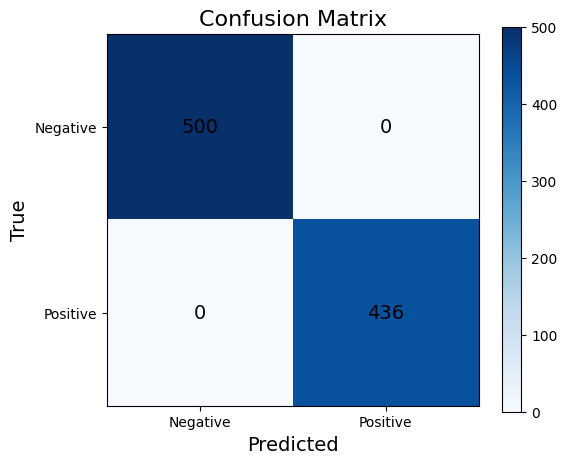

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")  


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=14)


ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("True", fontsize=14)
ax.set_title("Confusion Matrix", fontsize=16)

classes = ["Negative", "Positive"]
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

fig.colorbar(im, ax=ax)  
plt.show()


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Tiny or very simple test set where the model can easily memorize patterns. Overfitting: GAN may be too complex for small dataset, it might memorize all training examples and, by accident, the test set is too similar.

- It means the discriminator easily detects fake images
- The generator is still weak and produces low-quality fakes
- Training is unbalanced

Maybe the discriminator is too powerful, and the generator is not learning enough.